# 1 Dataset and Task
 (a) Select your choice of neural networks model that is suitable for this task and motivate it. Train your model
 to predict one step ahead data point, during training (see following Figure). Scale your data before training
 and scale them back to be able to compare your predictions with real measurements.
 
 (b) How many past time steps should you input into your network to achieve the best possible performance?
 (Hint: This is a tunable parameter and needs to be tuned).
 
 (c) Once your model is trained, use it to predict the next 200 data points recursively. This means feeding each
 prediction back into the model to generate the subsequent predictions.)
 
 (d) On May 9th, download the real test dataset and evaluate your model by reporting both the Mean Absolute
 Error (MAE) and Mean Squared Error (MSE) between its predictions and the actual test values. Additionally,
 create a plot comparing the predicted and real values to visually assess your models performance.

First, we load the data and take a look at it. We also install torch:

Data shape: (1000, 1)
Data type: uint8
Min value: 2
Max value: 255


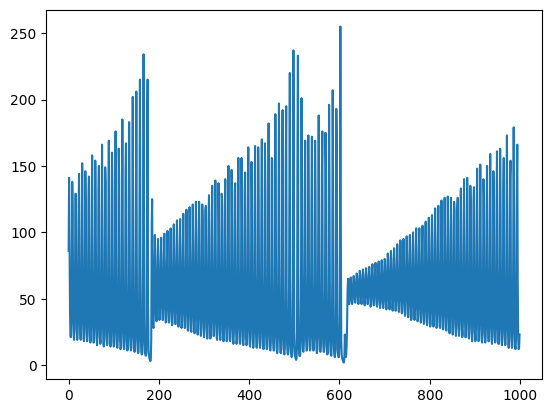

In [1]:
file = 'Xtrain.mat'
# load training data
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load the training data
data = scipy.io.loadmat(file)
X_train = data['Xtrain']

# Display basic information about the data
print(f"Data shape: {X_train.shape}")
print(f"Data type: {X_train.dtype}")
print(f"Min value: {np.min(X_train)}")
print(f"Max value: {np.max(X_train)}")

# plot the data
plt.plot(X_train)
plt.show()


Now, we scale the data, because then the network works better and faster. 
I also want to scale it back, so that it can get the right outputs.

In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler

#let's scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train.reshape(-1, 1))

#We also want the scaled back data ready:
restored_data = scaler.inverse_transform(scaled_data)

# Printing the first few values of the scaled and restored data to check
print(f"First few scaled values:\n{scaled_data[:5]}")
print(f"First few restored values:\n{restored_data[:5]}")

#Display basic information about the data
print(f"Data shape: {scaled_data.shape}")
print(f"Data type: {scaled_data.dtype}")
print(f"Min value: {np.min(scaled_data)}")
print(f"Max value: {np.max(scaled_data)}")

First few scaled values:
[[ 0.55720154]
 [ 1.73111118]
 [ 0.74929585]
 [-0.40326998]
 [-0.8088024 ]]
First few restored values:
[[ 86.]
 [141.]
 [ 95.]
 [ 41.]
 [ 22.]]
Data shape: (1000, 1)
Data type: float64
Min value: -1.2356786270219065
Max value: 4.16430570013708


In [37]:
#making the LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use output from last time step
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [38]:
from torch.utils.data import TensorDataset, DataLoader
#Now we want to create sequences from our data, then split into training and validation sets
seq_len = 30

#Define the function that retrieves the sequences:
def create_sequences(data, seq_len):
    sequences = []
    labels = []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]
        label = data[i+seq_len]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the split ratio for validation data
train_ratio = 0.9
val_ratio = 0.1

# Create sequences from scaled data
X_sequences, y_labels = create_sequences(scaled_data, seq_len)

# Convert to PyTorch tensors
X_sequences = torch.tensor(X_sequences, dtype=torch.float32)
y_labels = torch.tensor(y_labels, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(X_sequences, y_labels)

# Calculate sizes for train and validation
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset for train and validation
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create DataLoaders for training and validation
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print information about the splits
print(f"Total sequences: {dataset_size}")
print(f"Training sequences: {train_size}")
print(f"Validation sequences: {val_size}")


Total sequences: 970
Training sequences: 873
Validation sequences: 97


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import KFold

# hyperparameter tuning for seq_len
seq_len_options = [20,22,25,27,30,32,35,37,40,42,45,47,50]
k_folds = 5
hyperparameter_tuning_results = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f"Device for tuning: {device}")

# training parameters
num_epochs_tuning = 5000
patience_tuning = 20
batch_size_tuning = 512
lr_tuning = 0.0001
kfold_random_state = 42

for current_seq_len in seq_len_options:
    print(f"\n--- Evaluating seq_len: {current_seq_len} ---")

    # create sequences for current seq_len
    X_sequences_tune, y_labels_tune = create_sequences(scaled_data, current_seq_len)

    # convert to tensors and create dataset
    X_sequences_tune_tensor = torch.tensor(X_sequences_tune, dtype=torch.float32)
    y_labels_tune_tensor = torch.tensor(y_labels_tune, dtype=torch.float32)
    dataset_tune = TensorDataset(X_sequences_tune_tensor, y_labels_tune_tensor)
    
    dataset_size_tune = len(dataset_tune)
    print(f"  Total sequences for seq_len {current_seq_len}: {dataset_size_tune}")

    all_fold_best_val_losses = []
    
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=kfold_random_state)

    for fold_num, (train_idx, val_idx) in enumerate(kf.split(dataset_tune)):
        print(f"  --- Fold {fold_num + 1}/{k_folds} for seq_len: {current_seq_len} ---")
        
        train_dataset_tune = Subset(dataset_tune, train_idx)
        val_dataset_tune = Subset(dataset_tune, val_idx)

        train_loader_tune = DataLoader(train_dataset_tune, batch_size=batch_size_tuning, shuffle=True)
        val_loader_tune = DataLoader(val_dataset_tune, batch_size=batch_size_tuning, shuffle=False)

        print(f"  Training sequences: {len(train_dataset_tune)}, Validation sequences: {len(val_dataset_tune)}")

        # initialize model for this fold
        model_tune = LSTMModel(hidden_size=64, num_layers=1, dropout=0.1).to(device) 
        criterion_tune = nn.MSELoss()
        optimizer_tune = torch.optim.Adam(model_tune.parameters(), lr=lr_tuning)

        current_best_val_loss_for_this_fold = float('inf')
        epochs_no_improve_tune = 0
        
        for epoch in range(num_epochs_tuning):
            model_tune.train()
            epoch_train_loss = 0
            for X_batch, y_batch in train_loader_tune:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer_tune.zero_grad()
                output = model_tune(X_batch)
                loss = criterion_tune(output.squeeze(), y_batch.squeeze())
                loss.backward()
                optimizer_tune.step()
                epoch_train_loss += loss.item()
            epoch_train_loss /= len(train_loader_tune)

            model_tune.eval()
            epoch_val_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader_tune:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    output = model_tune(X_batch)
                    loss = criterion_tune(output.squeeze(), y_batch.squeeze())
                    epoch_val_loss += loss.item()
            epoch_val_loss /= len(val_loader_tune)
            
            if epoch_val_loss < current_best_val_loss_for_this_fold:
                current_best_val_loss_for_this_fold = epoch_val_loss
                epochs_no_improve_tune = 0
            else:
                epochs_no_improve_tune += 1
            
            if (epoch + 1) % 200 == 0 or epoch == num_epochs_tuning - 1 or epochs_no_improve_tune >= patience_tuning:
                 print(f"    Epoch {epoch+1}/{num_epochs_tuning} - Train: {epoch_train_loss:.5f} - Val: {epoch_val_loss:.5f} (Best Fold: {current_best_val_loss_for_this_fold:.5f})")

            if epochs_no_improve_tune >= patience_tuning:
                print(f"    Early stopping at epoch {epoch+1}. Best Val Loss for Fold: {current_best_val_loss_for_this_fold:.5f}")
                break
        
        all_fold_best_val_losses.append(current_best_val_loss_for_this_fold)
        print(f"  --- Fold {fold_num + 1} finished. Best Val Loss: {current_best_val_loss_for_this_fold:.5f} ---")

    mean_best_val_loss = float('inf')
    std_best_val_loss = float('nan')
    if all_fold_best_val_losses: 
        valid_losses = [loss for loss in all_fold_best_val_losses if loss != float('inf')]
        if valid_losses:
            mean_best_val_loss = np.mean(valid_losses)
            std_best_val_loss = np.std(valid_losses)
        
    hyperparameter_tuning_results[current_seq_len] = {
        'mean_best_val_loss': mean_best_val_loss,
        'std_best_val_loss': std_best_val_loss,
        'individual_trial_losses': all_fold_best_val_losses
    }
    print(f"--- Finished seq_len: {current_seq_len}. Mean Val Loss: {mean_best_val_loss:.5f} (Std: {std_best_val_loss:.5f}) ---")

best_seq_len_final = None
lowest_overall_mean_val_loss = float('inf')

if hyperparameter_tuning_results:
    for sl, results_dict in hyperparameter_tuning_results.items():
        current_mean_loss = results_dict.get('mean_best_val_loss', float('inf'))
        if current_mean_loss < lowest_overall_mean_val_loss:
            lowest_overall_mean_val_loss = current_mean_loss
            best_seq_len_final = sl

print(f"\n--- Hyperparameter Tuning Complete (K-Fold CV) ---")
print(f"All results:")
for sl, res_dict in sorted(hyperparameter_tuning_results.items()): 
    mean_loss = res_dict.get('mean_best_val_loss', float('inf'))
    std_loss = res_dict.get('std_best_val_loss', float('nan'))
    fold_losses = res_dict.get('individual_trial_losses', [])
    formatted_fold_losses = [f"{loss:.5f}" if loss != float('inf') else "inf" for loss in fold_losses]
    print(f"  Seq_len: {sl:3d} -> Mean: {mean_loss:.5f}, Std: {std_loss:.5f}, Fold Losses: {formatted_fold_losses}")

if best_seq_len_final is not None:
    print(f"\nBest sequence length: {best_seq_len_final}")
    print(f"Lowest mean validation loss: {lowest_overall_mean_val_loss:.5f}")
else:
    print("\nNo best sequence length found. All runs might have failed or been skipped.")


Device for tuning: mps
Starting hyperparameter tuning for seq_len with 5-fold cross-validation...

--- Evaluating seq_len: 20 ---
  Total sequences for seq_len 20: 980
  --- Fold 1/5 for seq_len: 20 ---
  Training sequences: 784, Validation sequences: 196
    Epoch 200/5000 - Train: 0.24120 - Val: 0.27226 (Best Fold: 0.27226)
    Epoch 400/5000 - Train: 0.07528 - Val: 0.15309 (Best Fold: 0.15243)
    Epoch 433/5000 - Train: 0.06415 - Val: 0.14987 (Best Fold: 0.14985)
    Early stopping at epoch 433. Best Val Loss for Fold: 0.14985
  --- Fold 1 finished. Best Val Loss: 0.14985 ---
  --- Fold 2/5 for seq_len: 20 ---
  Training sequences: 784, Validation sequences: 196
    Epoch 200/5000 - Train: 0.24340 - Val: 0.26752 (Best Fold: 0.26752)
    Epoch 400/5000 - Train: 0.13332 - Val: 0.11566 (Best Fold: 0.11566)
    Epoch 498/5000 - Train: 0.07355 - Val: 0.08357 (Best Fold: 0.08152)
    Early stopping at epoch 498. Best Val Loss for Fold: 0.08152
  --- Fold 2 finished. Best Val Loss: 0.0815

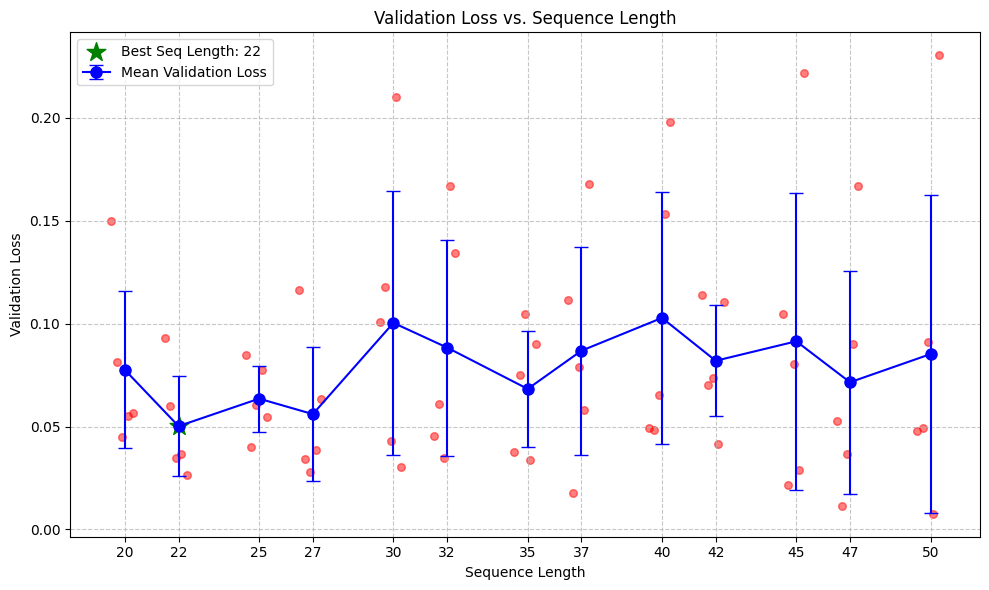

In [50]:
# Plot the validation losses for each sequence length
plt.figure(figsize=(10, 6))

# Prepare data for plotting
seq_lengths = []
mean_losses = []
std_losses = []
individual_losses = []

# Extract data from hyperparameter_tuning_results
for seq_len, results in sorted(hyperparameter_tuning_results.items()):
    seq_lengths.append(seq_len)
    mean_losses.append(results['mean_best_val_loss'])
    std_losses.append(results['std_best_val_loss'])
    individual_losses.append(results['individual_trial_losses'])

# Plot mean validation loss with error bars
plt.errorbar(seq_lengths, mean_losses, yerr=std_losses, fmt='o-', capsize=5, 
             label='Mean Validation Loss', color='blue', markersize=8)

# Plot individual trial losses for each sequence length
for i, (seq_len, trials) in enumerate(zip(seq_lengths, individual_losses)):
    # Create slight horizontal offset for better visibility
    x_jittered = [seq_len + (j - len(trials)/2) * 0.2 for j in range(len(trials))]
    plt.scatter(x_jittered, trials, color='red', alpha=0.5, s=30)

# Highlight the best sequence length
if best_seq_len_final is not None:
    best_idx = seq_lengths.index(best_seq_len_final)
    plt.scatter(seq_lengths[best_idx], mean_losses[best_idx], color='green', 
                s=200, marker='*', label=f'Best Seq Length: {best_seq_len_final}')

# Add labels and title
plt.xlabel('Sequence Length')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Sequence Length')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Ensure x-axis shows all sequence lengths
plt.xticks(seq_lengths)

plt.tight_layout()
plt.show()
